In [1]:
!date

Thu Jun 29 08:36:37 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-ADHD'

In [3]:
import ants
import numpy as np
import pandas as pd
import os

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [4]:
import numpy as np
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0


In [5]:
brain_size = (64,64,64)

In [6]:
temp = ants.image_read('./Misc/Atlas_brain_2mm.nii')
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize()

In [7]:
temp.max()

1.0

In [8]:
# brain_size = temp.shape
# print(brain_size)

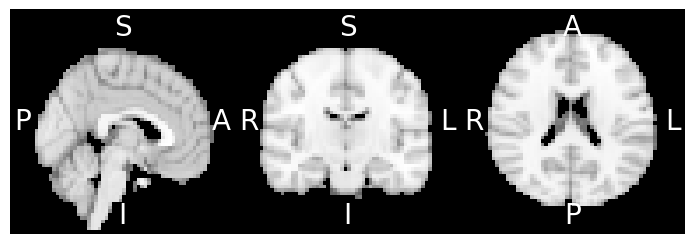

In [9]:
temp.plot_ortho(flat=True,xyz_lines=False)

In [10]:
coords = (32,32,50)

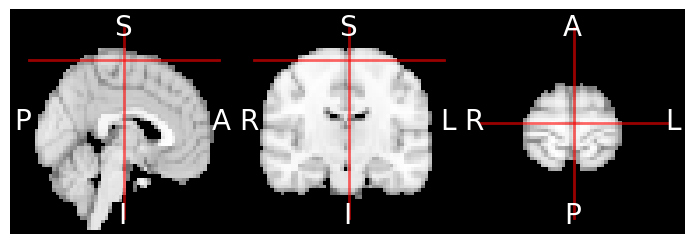

In [11]:
temp.plot_ortho(flat=True,xyz=coords)

In [12]:
sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=2, position=coords)*1.0)
sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=8, position=coords)*1.0)
#.plot_ortho(flat=True,xyz=[32,32,32])

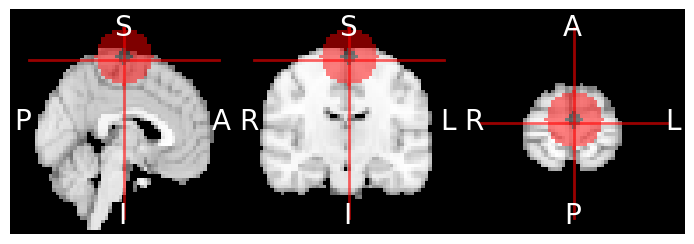

In [13]:
temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5)

In [14]:
#mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big,type_of_transform = 'SyN' )
mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big,type_of_transform = 'SyNOnly' )

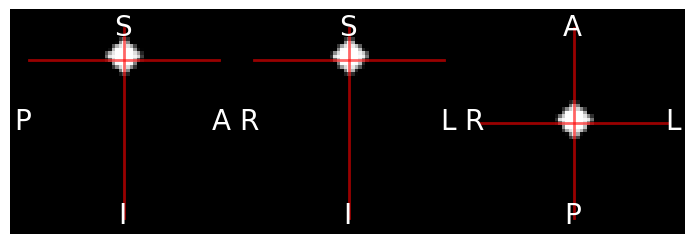

In [15]:
mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)

/scratch/aglinska/tmplb5u6wf21Warp.nii.gz


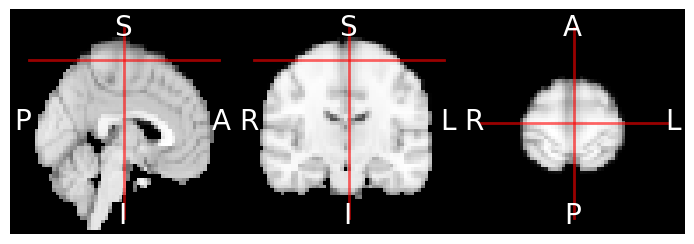

In [16]:
warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0])
print(mytx['fwdtransforms'][0])
warpedBrain.plot_ortho(flat=True,xyz=coords)

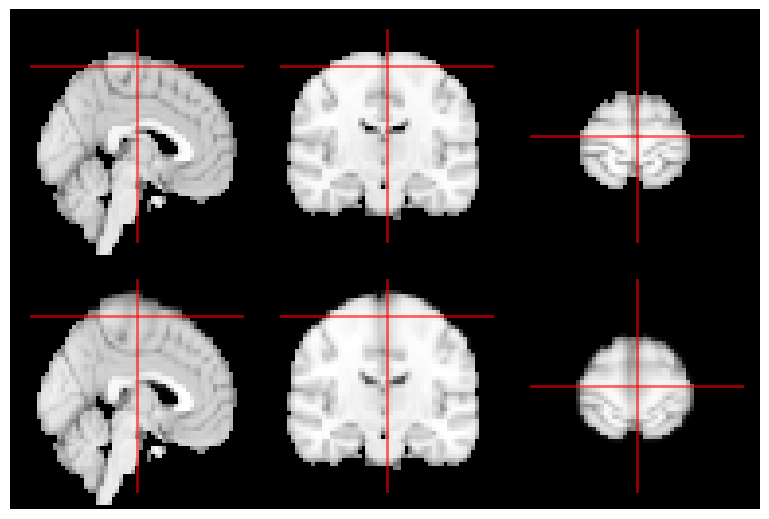

In [17]:
temp.plot_ortho_double(warpedBrain,xyz=coords)

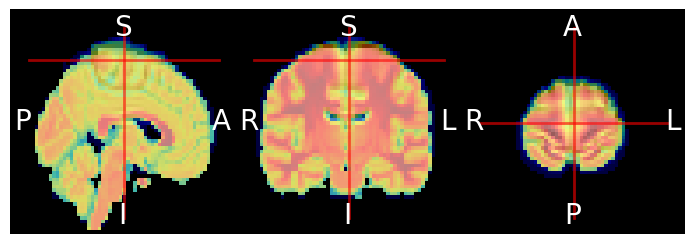

In [18]:
temp.plot_ortho(warpedBrain,flat=True,overlay_alpha=.5,xyz=coords)

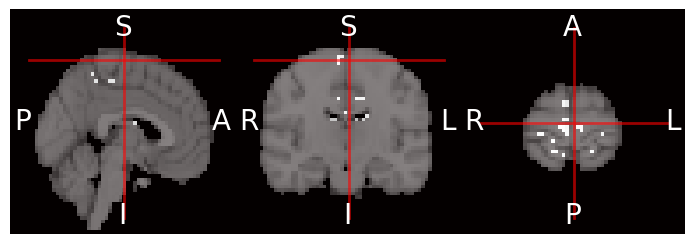

In [19]:
temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)

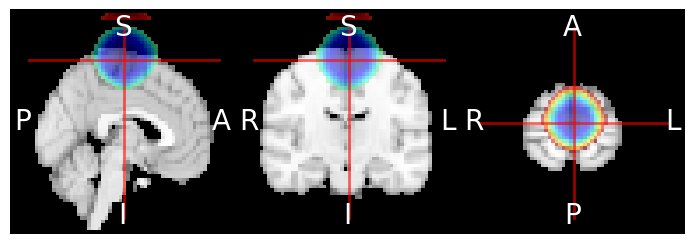

In [20]:
J = ants.create_jacobian_determinant_image(domain_image=temp,tx=mytx['fwdtransforms'][0])
J = J-1
J[abs(J.numpy())<.25]=0
temp.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords)

In [30]:
## AA ADD BSPline interpolation somewhere
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2,do_plot=True):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    if do_plot==True:
        temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly' ) # learns a vector field from small to big sphere
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline') # applies the transformation
    
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='nearestNeighbor')
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    if do_plot==True:
        temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22)
        (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map')
        
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    
    J = ants.create_jacobian_determinant_image(domain_image=warpedBrain,tx=mytx['fwdtransforms'][0])
    J = J-1
    #J[abs(J.numpy())<.25]=0
    if do_plot==True:
        warpedBrain.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

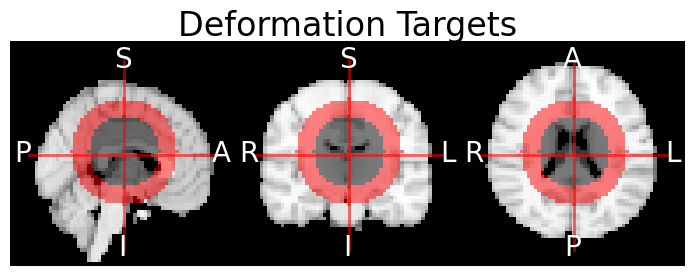

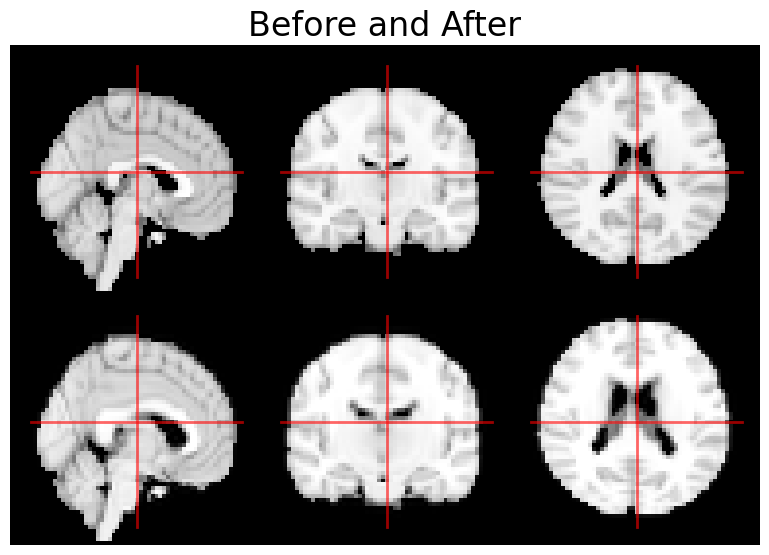

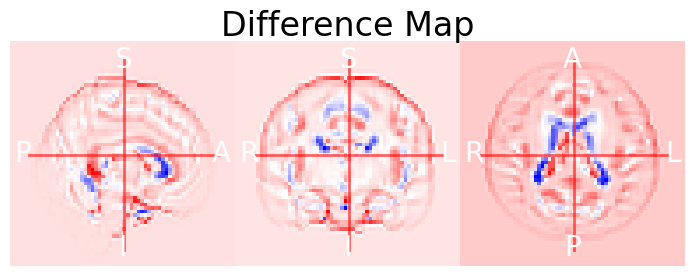

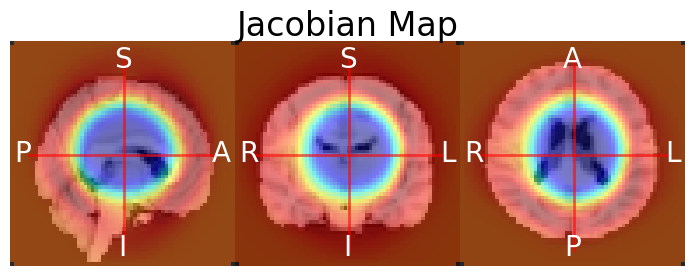

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64, 64)
	 Spacing    : (2.8571, 3.4286, 2.8571)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [43]:
#do_selective_tx(temp,coords = (32,32,32),sz1=30,sz2=25) # Global compress realistic
#do_selective_tx(temp,coords = (32,32,32),sz1=25,sz2=30) # Global inflate realistic
do_selective_tx(temp,coords = (32,32,32),sz1=10,sz2=15) # SIM 16p11.2 duplication
#do_selective_tx(temp,coords = (32,32,32),sz1=16,sz2=12) # SIM 16p11.2 deletion
#do_selective_tx(temp,coords = (32,32,32),sz1=2,sz2=8); # Expand Ventricles
#do_selective_tx(temp,coords = (32,50,22),sz1=8,sz2=1); # Shrink OFC
#do_selective_tx(temp,coords = (32,50,22),sz1=4,sz2=2); # Shrink OFC

### FUN TIMES 

#do_selective_tx(temp,coords = (32,32,32),sz1=20,sz2=15) # Global compress realistic
#do_selective_tx(temp,coords = (32,32,32),sz1=25,sz2=35) # Global inflate realistic
#do_selective_tx(temp,coords = (32,32,32),sz1=2,sz2=8); # Expand Ventricles
#do_selective_tx(temp,coords = (32,50,22),sz1=8,sz2=6); # Expand OFC
#do_selective_tx(temp,coords = (32,48,25),sz1=15,sz2=10); # Shrink OFC